# QC of TMT labeled phosphoproteome data of the sinus node 
## searched with MaxQuant v.1.6.10.43 with unitprot reviewed mouse DB, without isoforms, with PIF cutoff (0.75) and iBAQ calculation enabled

### Author: Konstantin Kahnert
### Date: 2020_09_14

### Load required libraries


In [41]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Define required functions

In [80]:
def calculate_missed_cleavage_rate(path_peptides):
    """
    calculates the fraction of peptides with one or two missed cleavages

    input: peptides.txt

    returns: (total MC rate, 1 MC rate, 2 MC rate)
    """
    # # load data into a pandas dataframe
    df_peptides = pd.read_table(path_peptides)

    # # count number of missed cleavages
    num_MC = df_peptides["Missed cleavages"].value_counts()

    # # calculate MC rates
    total_MC_rate = (num_MC[1] + num_MC[2]) / sum(num_MC) * 100
    MC_rate_1 = num_MC[1] / sum(num_MC) * 100
    MC_rate_2 = num_MC[2] / sum(num_MC) * 100

    return [total_MC_rate, MC_rate_1, MC_rate_2]


def calculate_percent_cysteines(path_peptides):
    """
    calculates the percentage of cysteines based on MaxQuant output file 'peptides.txt'
    input: peptides.txt

    returns: fraction of peptides with a cysteine
    """
    # # load data into a pandas dataframe
    df_peptides = pd.read_table(path_peptides)

    # # count number peptides
    num_peptides = len(df_peptides)

    # # count number of peptide containing a C
    num_peptide_C = sum(df_peptides["Sequence"].apply(lambda x: "C" in x))

    # # calculate fraction of peptides containing a C
    C_fraction = num_peptide_C / num_peptides * 100

    return C_fraction


def plot_density_curves(df, title=""):
    """
    Takes a data frame and plots the density curve of each column into one plot

    input: pandas dataframe (all columns are plotted)
    title: str, title of the plot

    returns: figure
    """
    # set plot style to white background
    sns.set_style("white")

    # create new figure
    fig = plt.figure(figsize=(8, 8))

    # iterate through all samples
    for sample in df.columns:

        # extract column of given sample
        df_sample = df[sample]

        # draw density curve
        sns.distplot(df_sample, hist=False, kde=True, kde_kws={'linewidth': 1}, label=sample)

    # Plot formatting
    plt.legend(prop={'size': 8, "weight": "bold"}, title='Sample')
    plt.title(title)
    plt.xlabel('log2(Intensity)', weight="bold")
    plt.ylabel('Density', weight="bold")

    return fig


def plot_sample_correlation(df, title=""):
    """
    Calculates pearson correlations between samples and visualizes them by plotting a heat map

    input: pandas dataframe (all columns are plotted)
    title: str, title of the plot

    returns: figure
    """
    # # calculate pearson correlation matrix
    df_corr = df.corr(method="pearson")

    # # create mask to only show lower right triangle of the heatmap
    # create matrix containing only zeros of same dimension as df_proteinGroups_log_corr
    mask = np.zeros_like(df_corr)

    # set values of upper right triangle to ones (fields with 1 will not be displayed in the plot)
    mask[np.triu_indices_from(mask)] = True

    # invert the matrix (so that the diagonal is not covered)
    # and flip it around so that so upper left triangle is covered (=1)
    mask = np.invert(mask.astype(bool)).astype(int)[::-1]

    # # create heatmap to visualize the pearson correlations
    # change font size
    sns.set(font_scale=1.1)

    # set style
    with sns.axes_style("white"):
        # initialize new figure
        fig, ax = plt.subplots(figsize=(8, 6))

        # plot heatmap and use mask to cover upper left triangle and color bar on the left side
        ax = sns.heatmap(df_corr[::-1], linewidths=.5, annot=True, mask=mask, square=True,
                         cmap="Reds", vmin=0.8, vmax=1, cbar_kws=dict(use_gridspec=False, location="left",
                                                                      anchor=(1.65, 0.5)))

        # move y axis ticks to the right side of the plot
        ax.yaxis.tick_right()

        # rotate y tick labels to be displayed horizontally
        plt.yticks(rotation='horizontal')

        # set y axis label
        plt.ylabel("Pearson Correlation", weight="bold", fontsize=15)

        # move y axis label to the left to not overlap with the color bar
        ax.yaxis.set_label_coords(-0.25, 0.5)

        # display x axis ticks
        ax.xaxis.tick_bottom()

        # rotate x tick labels to be displayed in a 45 degree angle
        plt.xticks(rotation=45)

        # change tick label size
        ax.tick_params(axis='both', which='major', labelsize=12)

        # set x axis lable
        plt.xlabel("Sample", weight="bold", fontsize=15)

        # add title
        plt.suptitle(title, weight="bold", fontsize=15)

        return fig


def plot_boxplot(df, title="Intensities per Sample"):
    """
    Not finished yet!

    Creates a box and whisker plot

    returns: figure
    """
    # create nnew figure
    fig, ax = plt.subplots(figsize=(20, 6))

    # plot boxplot
    sns.boxplot(x="Sample", y="Intensity", data=df,
                hue="Group", palette="Set1", width=1.2, ax=ax, notch=True)

    # set x axis limits
    plt.xlim(-1, 30)

    # move legend outside of the plot area
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., title="Group")

    # set axis labels
    plt.xlabel("Sample", weight="bold")
    plt.ylabel("log2(Intensity)", weight="bold")

    # add title
    plt.title(title, weight="bold")

    return fig


def save_figure(fig, name):

    # create new path name for saving the figure as pdf
    path_fig = folder_output + "\\" + name + ".pdf"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight")

    # create new path name for saving the figure as png
    path_fig = folder_output + "\\" + name + ".png"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight", dpi=600)

    return None


###  Specify location of the MaxQuant proteinGroups.txt file and use it to generate the path of the required files


In [43]:
# specify location of the MaxQuant proteinGroups.txt file
path_txt_folder = r"E:\Data\Heart_failure_mice_CS\Sinus_node\Phosphoproteome\Analysis\01_QC\combined\txt"

# # set paths for required files (don't change this)
path_phosphoSTY = path_txt_folder + r"\Phospho (STY)Sites.txt"
path_evidence = path_txt_folder + r"\evidence.txt"
path_peptides= path_txt_folder + r"\peptides.txt"
path_summary = path_txt_folder + r"\summary.txt"

# set path for output
folder_output = path_txt_folder

### Specifiy which labels/channels were used for which samples
In MaxQuant the column of interest for the further analysis is the "Reporter intensity corrected [1-10]" for a TMT 10plex experiment. Numbers are corresponding to the different labels as specified below.

In [44]:
# don't change this
MQ_channels_to_TMT_labels = {"1": "126C", "2": "127N", "3": "127C", "4": "128N", "5": "128C",
                              "6": "129N", "7": "129C", "8": "130N", "9": "130C", "10": "131N"}

# change this to your sample identifiers
TMT_labels_to_samples = {"126C": 'Sham 1', '127N': 'Sham 2', '127C': 'Sham 3', '128N': 'Sham 4', '128C': 'Sham 5',
                          '129N': 'TAC 1', '129C': 'TAC 2', '130N': 'TAC 3', '130C': 'TAC 4', '131N': 'TAC 5'}

### Load Phospho (STY)sites.txt file into a pandas dataframe and create identifier from Phospho (STY) Probabilities and Positions columns and set as index

In [60]:
# load data into a pandas dataframe
df_phosphosites = pd.read_table(path_phosphoSTY)

# create protein/gene column
identifier_col = df_phosphosites["Phospho (STY) Probabilities"].astype(str) + "|" + df_phosphosites["Positions"].astype(str)

# set protein_gene_col column as index
df_phosphosites.set_index(identifier_col, inplace=True)

# show head of df 
df_phosphosites.head(5)

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (17,222) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Proteins,Positions within proteins,Leading proteins,Protein,Protein names,Gene names,Fasta headers,Localization prob,Score diff,PEP,...,Best localization raw file,Best localization scan number,Best score evidence ID,Best score MS/MS ID,Best score raw file,Best score scan number,Best PEP evidence ID,Best PEP MS/MS ID,Best PEP raw file,Best PEP scan number
S(0.114)S(0.114)S(0.422)S(0.35)PGGS(0.001)LDLVSALEDYEEPFPVYQK|62,P0DPB4;A0A088MLT8,62;137,P0DPB4,P0DPB4,NaN,Schip1,SCHI1_MOUSE Schwannomin-interacting protein 1 ...,0.421897,0.81627,0.000004,...,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,13091,64949,35901,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,13091,64949,35901,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,13091
TETSLDT(0.001)PLS(0.995)PMS(0.005)K|327,P0DPB4;A0A088MLT8,327;402,P0DPB4,P0DPB4,NaN,Schip1,SCHI1_MOUSE Schwannomin-interacting protein 1 ...,0.994542,23.15830,0.001664,...,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8019,67468,37230,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8019,67468,37230,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8019
QAS(1)LDGLQQLR|560,A1A5B6,560,A1A5B6,A1A5B6,TBC1 domain family member 25,Tbc1d25,TBC25_MOUSE TBC1 domain family member 25 OS=Mu...,1.000000,101.45200,0.000152,...,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8661,51603,29023,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8661,51603,29023,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8661
GS(1)PVSGR|276,A2A5R2,276,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-excha...,Arfgef2,BIG2_MOUSE Brefeldin A-inhibited guanine nucle...,0.999887,39.45890,0.003385,...,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,2037,20828,11582,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,1657,20828,11582,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,1657
GQS(0.997)QLS(0.959)NPT(0.043)DDS(0.001)WK|1532,A2A5R2,1532,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-excha...,Arfgef2,BIG2_MOUSE Brefeldin A-inhibited guanine nucle...,0.997114,25.25570,0.002228,...,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8690,29243,16486,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8690,29243,16486,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8690


### Count total number of phosphosites

In [61]:
# count total number of proteins
num_sites_total = len(df_phosphosites)
print(num_sites_total)

7393


### Count the number of decoys, contaminants and only identified by site hits and remove them

In [62]:
# count number of decoys, contaminats and only identified by site
num_decoys = len(df_phosphosites[df_phosphosites["Reverse"] == "+"])
num_contaminats = len(df_phosphosites[df_phosphosites["Potential contaminant"] == "+"])

# remove decoys, contaminats and only identified by site identifications
df_phosphosites = df_phosphosites[df_phosphosites["Reverse"] != "+"]
df_phosphosites = df_phosphosites[df_phosphosites["Potential contaminant"] != "+"]

print(num_decoys, num_contaminats)

56 16


### Reduce the dataframe to the columns of interest (Reporter intensity corrected [1-10])

In [48]:
# remove all unnecessary columns, i.e. just keep "Reporter intensity corrected [1-10]" columns
df_phosphosites_reduced = df_phosphosites.filter(regex="Reporter intensity corrected [0-9]+_")

df_phosphosites_reduced.head(5)

,Reporter intensity corrected 1___1,Reporter intensity corrected 1___2,Reporter intensity corrected 1___3,Reporter intensity corrected 2___1,Reporter intensity corrected 2___2,Reporter intensity corrected 2___3,Reporter intensity corrected 3___1,Reporter intensity corrected 3___2,Reporter intensity corrected 3___3,Reporter intensity corrected 4___1,...,Reporter intensity corrected 7___3,Reporter intensity corrected 8___1,Reporter intensity corrected 8___2,Reporter intensity corrected 8___3,Reporter intensity corrected 9___1,Reporter intensity corrected 9___2,Reporter intensity corrected 9___3,Reporter intensity corrected 10___1,Reporter intensity corrected 10___2,Reporter intensity corrected 10___3
S(0.114)S(0.114)S(0.422)S(0.35)PGGS(0.001)LDLVSALEDYEEPFPVYQK|62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TETSLDT(0.001)PLS(0.995)PMS(0.005)K|327,106080.0,0.0,0.0,97753.0,0.0,0.0,81313.0,0.0,0.0,120230.0,...,0.0,134610.0,0.0,0.0,80324.0,0.0,0.0,204710.0,0.0,0.0
QAS(1)LDGLQQLR|560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GS(1)PVSGR|276,64652.0,0.0,0.0,30833.0,0.0,0.0,45241.0,0.0,0.0,46259.0,...,0.0,59298.0,0.0,0.0,33476.0,0.0,0.0,77230.0,0.0,0.0
GQS(0.997)QLS(0.959)NPT(0.043)DDS(0.001)WK|1532,0.0,19985.0,0.0,0.0,18771.0,0.0,0.0,22522.0,0.0,0.0,...,0.0,0.0,26517.0,0.0,0.0,23334.0,0.0,0.0,39798.0,0.0


#### Map columns to sample and rename columns
This uses the information provided in TMT_labels_to_samples and the preset info in MQ_channels_to_TMT_labels to rename the "Reporter intensity corrected [1-10]" columns to "RIc " + provided sample names, e.g. "RIc SN 1"

In [49]:
# rename columns
df_phosphosites_reduced.columns = ["Sham 1___1", "Sham 1___2", "Sham 1___3", 
                                   "Sham 2___1", "Sham 2___2", "Sham 2___3", 
                                   "Sham 3___1", "Sham 3___2", "Sham 3___3", 
                                   "Sham 4___1", "Sham 4___2", "Sham 4___3", 
                                   "Sham 5___1", "Sham 5___2", "Sham 5___3", 
                                   "TAC 1___1", "TAC 1___2", "TAC 1___3", 
                                   "TAC 2___1", "TAC 2___2", "TAC 2___3", 
                                   "TAC 3___1", "TAC 3___2", "TAC 3___3", 
                                   "TAC 4___1", "TAC 4___2", "TAC 4___3", 
                                   "TAC 5___1", "TAC 5___2", "TAC 5___3"]
    
df_phosphosites_reduced.head(5)

,Sham 1___1,Sham 1___2,Sham 1___3,Sham 2___1,Sham 2___2,Sham 2___3,Sham 3___1,Sham 3___2,Sham 3___3,Sham 4___1,...,TAC 2___3,TAC 3___1,TAC 3___2,TAC 3___3,TAC 4___1,TAC 4___2,TAC 4___3,TAC 5___1,TAC 5___2,TAC 5___3
S(0.114)S(0.114)S(0.422)S(0.35)PGGS(0.001)LDLVSALEDYEEPFPVYQK|62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TETSLDT(0.001)PLS(0.995)PMS(0.005)K|327,106080.0,0.0,0.0,97753.0,0.0,0.0,81313.0,0.0,0.0,120230.0,...,0.0,134610.0,0.0,0.0,80324.0,0.0,0.0,204710.0,0.0,0.0
QAS(1)LDGLQQLR|560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GS(1)PVSGR|276,64652.0,0.0,0.0,30833.0,0.0,0.0,45241.0,0.0,0.0,46259.0,...,0.0,59298.0,0.0,0.0,33476.0,0.0,0.0,77230.0,0.0,0.0
GQS(0.997)QLS(0.959)NPT(0.043)DDS(0.001)WK|1532,0.0,19985.0,0.0,0.0,18771.0,0.0,0.0,22522.0,0.0,0.0,...,0.0,0.0,26517.0,0.0,0.0,23334.0,0.0,0.0,39798.0,0.0


### Count how many proteins in each samples were identified but not quantified and remove proteins that were not quantified in all samples

In [50]:
# replace zeros by NaN
df_phosphosites_reduced.replace(0, np.nan, inplace=True)

# count how many proteins weren't quantified in all samples and remove them
num_before = len(df_phosphosites_reduced)
df_proteinGroups_reduced = df_phosphosites_reduced.dropna(how="all")
num_after = len(df_phosphosites_reduced)
num_invalid_values_for_all = num_before - num_after

# for each sample, count how many proteins weren't quantified in sample but at least in one other sample
num_invalid_values = df_phosphosites_reduced.isna().sum()

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


### Print summary of the previous analysis and filtering

In [51]:
# create text
stats = "ThePhospho (STY)Sites.txt file contains " + str(num_sites_total) + " phospho (STY) sites in total. \n" \
        "Of those: \n" + str(num_decoys) + " sites are decoy hits, \n" \
        + str(num_contaminats) + " sites are potential contaminants, \n" \
        "and " + str(num_invalid_values_for_all) + " sites were not quantified in any of the samples. \n\n" \
        "After filtering, " + str(num_after) + " sites valid remain, \nwith the following numbers of missing " \
        "values per sample: \n" + str(num_invalid_values)[:-12]

# print text
print(stats)

ThePhospho (STY)Sites.txt file contains 7393 phospho (STY) sites in total. 
Of those: 
56 sites are decoy hits, 
16 sites are potential contaminants, 
and 0 sites were not quantified in any of the samples. 

After filtering, 7322 sites valid remain, 
with the following numbers of missing values per sample: 
Sham 1___1    2558
Sham 1___2    6008
Sham 1___3    7117
Sham 2___1    2558
Sham 2___2    6006
Sham 2___3    7117
Sham 3___1    2557
Sham 3___2    6006
Sham 3___3    7117
Sham 4___1    2557
Sham 4___2    6006
Sham 4___3    7117
Sham 5___1    2558
Sham 5___2    6006
Sham 5___3    7117
TAC 1___1     2557
TAC 1___2     6006
TAC 1___3     7117
TAC 2___1     2563
TAC 2___2     6007
TAC 2___3     7117
TAC 3___1     2557
TAC 3___2     6006
TAC 3___3     7117
TAC 4___1     2564
TAC 4___2     6009
TAC 4___3     7117
TAC 5___1     2557
TAC 5___2     6006
TAC 5___3     7117



### Determining missed cleavage rate

In [52]:
MC_rates = calculate_missed_cleavage_rate(path_peptides)

#print text describing missed cleavage rates
text_MC = str(round(MC_rates[0], 1)) + " % of the peptides have missed cleavages.\n" + \
   str(round(MC_rates[1], 1)) + " % of the peptides have one missed cleavages.\n" + \
   str(round(MC_rates[2], 1)) + " % of the peptides have two missed cleavages.\n"

print(text_MC)

16.4 % of the peptides have missed cleavages.
15.3 % of the peptides have one missed cleavages.
1.1 % of the peptides have two missed cleavages.



### Determining cysteine alkylation efficiency


In [53]:
cystein_frac = calculate_percent_cysteines(path_peptides)

### print text describing cysteine fraction
text_C_frac = str(round(cystein_frac, 1)) + " % of the peptides have at least one cysteine.\n"
print(text_C_frac)

8.4 % of the peptides have at least one cysteine.



### Get MS/MS spectra number, identification rates and number of peptides identified


In [54]:
# load summary.txt to pandas dataframe
df_summary = pd.read_table(path_summary, index_col=0)

# extract number of recordes spectra
num_spectra = df_summary["MS/MS"]

# extract ID rates
ID_rate = df_summary["MS/MS Identified [%]"]

# extract number of peptides identified
num_peptides = df_summary["Peptide Sequences Identified"]

# print text showing results
text_summary = str(num_spectra["Total"]) + " spectra have been recorded of which\n" + \
   str(round(ID_rate["Total"], 2)) + " % have been identified in total.\n\n" + \
   str(num_peptides["Total"]) + " Peptides have been identified in total."

print(text_summary)

137817 spectra have been recorded of which
31 % have been identified in total.

10461 Peptides have been identified in total.


### Save results as report to txt file

In [55]:
# create new path name for saving results
path_report = folder_output + "\\QC_report.txt"

# open file
with open(path_report, "w") as text_file:
    print("Data QC Report\n\n", file=text_file)
    print("Summary\n", file=text_file)
    print(stats + "\n\n", file=text_file)
    print("Digestion efficiency\n", file=text_file)
    print(text_MC + "\n\n", file=text_file)
    print("Alcylation efficiency\n", file=text_file)
    print(text_C_frac + "\n\n", file=text_file)
    print("Identification rate\n", file=text_file)
    print(text_summary, file=text_file)
    
# print full report
print("Data QC Report\n\n")
print("Summary\n")
print(stats + "\n\n")
print("Digestion efficiency\n")
print(text_MC + "\n\n")
print("Alcylation efficiency\n")
print(text_C_frac + "\n\n")
print("Identification rate\n")
print(text_summary)

Data QC Report


Summary

ThePhospho (STY)Sites.txt file contains 7393 phospho (STY) sites in total. 
Of those: 
56 sites are decoy hits, 
16 sites are potential contaminants, 
and 0 sites were not quantified in any of the samples. 

After filtering, 7322 sites valid remain, 
with the following numbers of missing values per sample: 
Sham 1___1    2558
Sham 1___2    6008
Sham 1___3    7117
Sham 2___1    2558
Sham 2___2    6006
Sham 2___3    7117
Sham 3___1    2557
Sham 3___2    6006
Sham 3___3    7117
Sham 4___1    2557
Sham 4___2    6006
Sham 4___3    7117
Sham 5___1    2558
Sham 5___2    6006
Sham 5___3    7117
TAC 1___1     2557
TAC 1___2     6006
TAC 1___3     7117
TAC 2___1     2563
TAC 2___2     6007
TAC 2___3     7117
TAC 3___1     2557
TAC 3___2     6006
TAC 3___3     7117
TAC 4___1     2564
TAC 4___2     6009
TAC 4___3     7117
TAC 5___1     2557
TAC 5___2     6006
TAC 5___3     7117



Digestion efficiency

16.4 % of the peptides have missed cleavages.
15.3 % of the peptides h

## Visualization

### Visualize intensity distribution of all samples

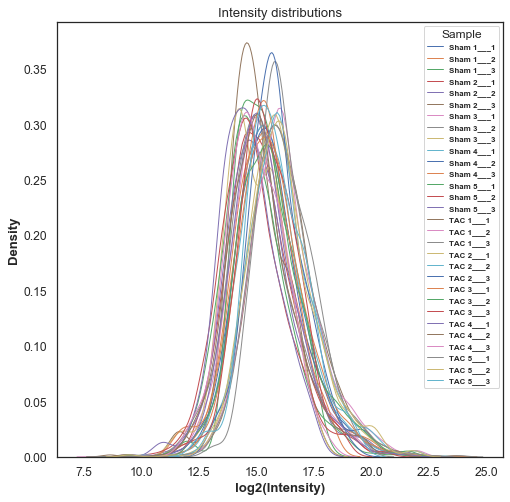

In [67]:
# log2 transform intensities
df_phosphosites_log = df_phosphosites_reduced.apply(np.log2)

# plot density curves
density_plot = plot_density_curves(df_phosphosites_log, title="Intensity distributions")

save_figure(density_plot, "intensity_distribution_plot")


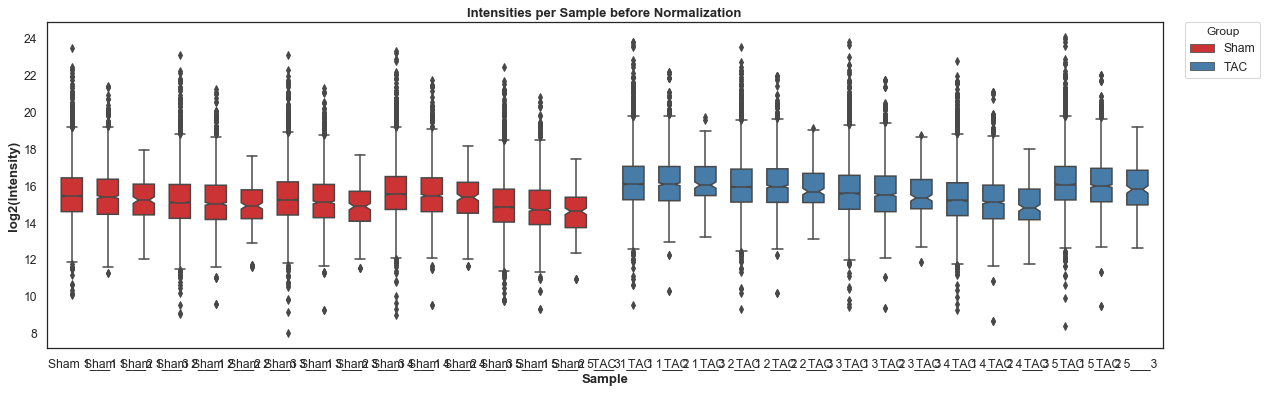

In [68]:
# plot boxplots of intensities per sample
# create dictionary mapping samples to experimental group
dict_samples = {"Sham 1___1": "Sham", "Sham 1___2": "Sham", "Sham 1___3": "Sham", 
                "Sham 2___1": "Sham", "Sham 2___2": "Sham", "Sham 2___3": "Sham", 
                "Sham 3___1": "Sham", "Sham 3___2": "Sham", "Sham 3___3": "Sham", 
                "Sham 4___1": "Sham", "Sham 4___2": "Sham", "Sham 4___3": "Sham", 
                "Sham 5___1": "Sham", "Sham 5___2": "Sham", "Sham 5___3": "Sham", 
                "TAC 1___1": "TAC", "TAC 1___2": "TAC", "TAC 1___3": "TAC", 
                "TAC 2___1": "TAC", "TAC 2___2": "TAC", "TAC 2___3": "TAC", 
                "TAC 3___1": "TAC", "TAC 3___2": "TAC", "TAC 3___3": "TAC", 
                "TAC 4___1": "TAC", "TAC 4___2": "TAC", "TAC 4___3": "TAC", 
                "TAC 5___1": "TAC", "TAC 5___2": "TAC", "TAC 5___3": "TAC"}

# melt dataframe
df_phosphosites_log_melt = pd.melt(df_phosphosites_log, var_name='Sample', value_name='Intensity')

# add group columns
df_phosphosites_log_melt["Group"] = df_phosphosites_log_melt["Sample"].map(dict_samples)

# create box plots
boxplot = plot_boxplot(df_phosphosites_log_melt, title="Intensities per Sample before Normalization")

# save plot
save_figure(boxplot, "intensity_boxplot_before_norm")

### Visualize correlation between samples

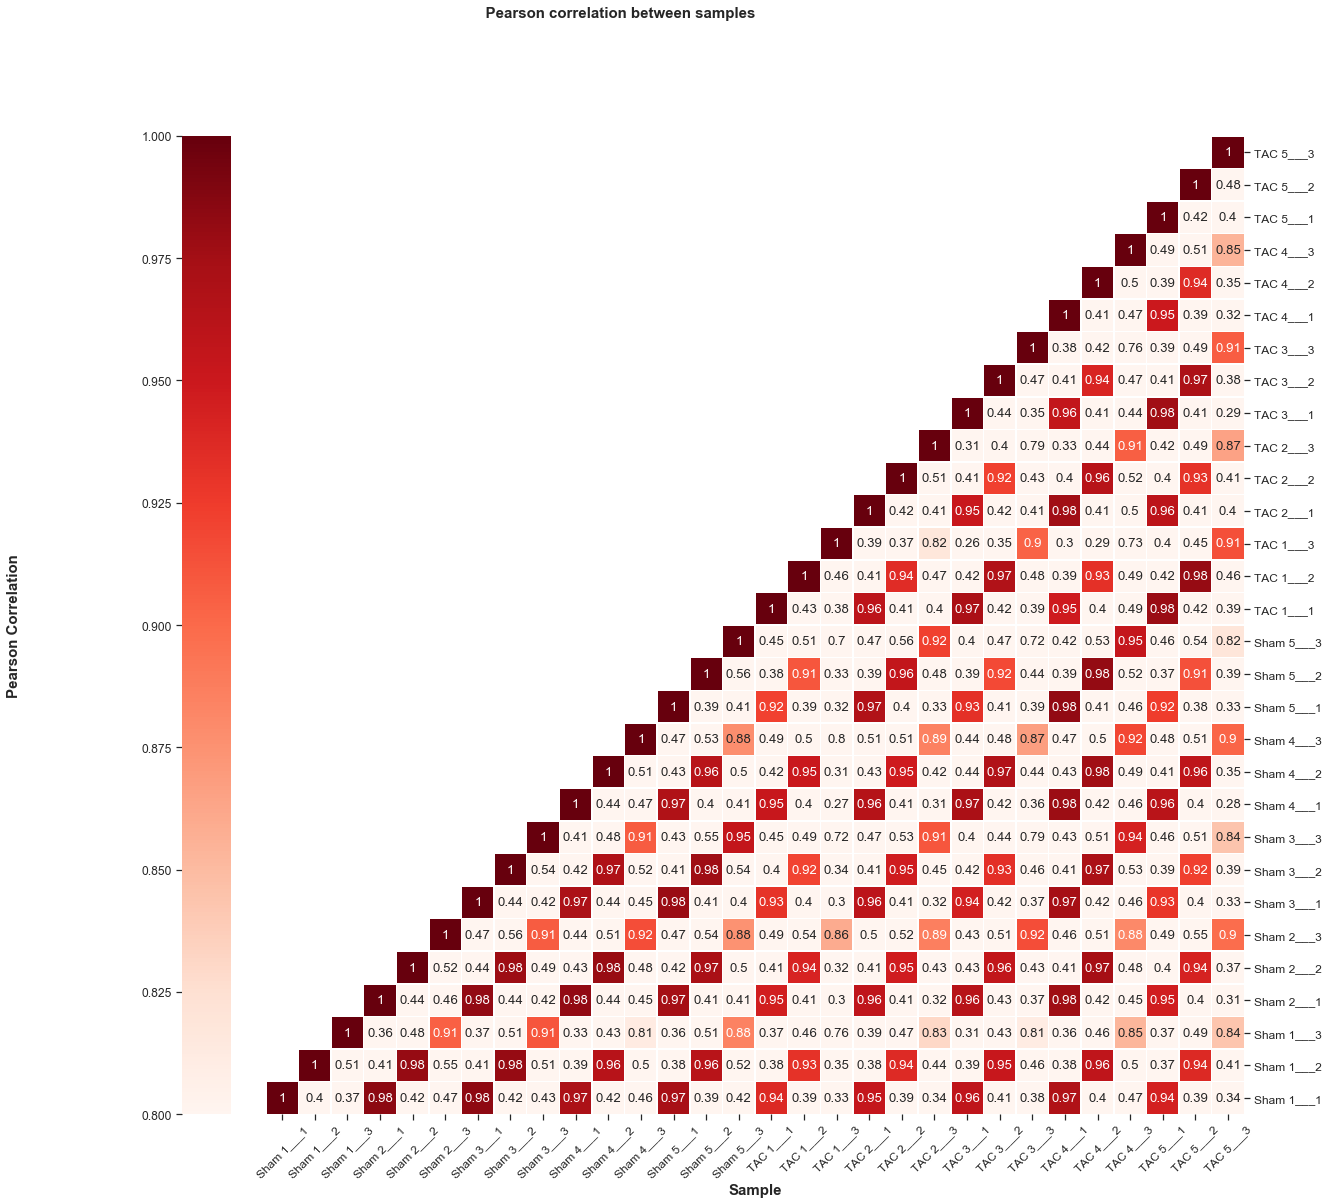

In [70]:
# # calculate pearson correlation between samples and visualize by plotting a heat map
corr_plot = plot_sample_correlation(df_phosphosites_log, title="                    Pearson correlation between samples")

save_figure(corr_plot, "sample_correlation")

## Visualize correlation between samples for each multiplicity individually

### Multiplicity 1

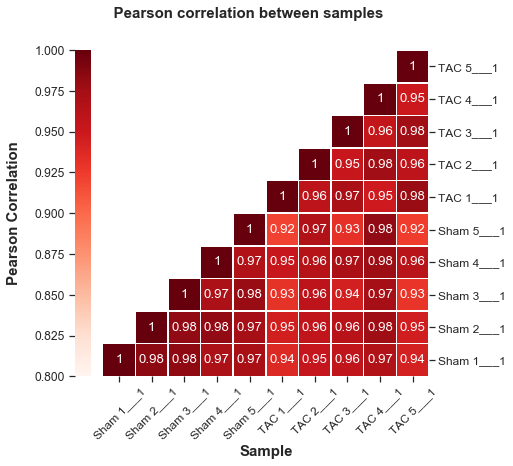

In [81]:
# filter df_phosphosites_log for monophosphorylated peptides
df_phosphosites_log__1 = df_phosphosites_log.filter(regex="___1")

# calculate pearson correlation between samples and visualize by plotting a heat map
corr_plot = plot_sample_correlation(df_phosphosites_log__1, title="                    Pearson correlation between samples")

save_figure(corr_plot, "sample_correlation___1")

### Multiplicity 2

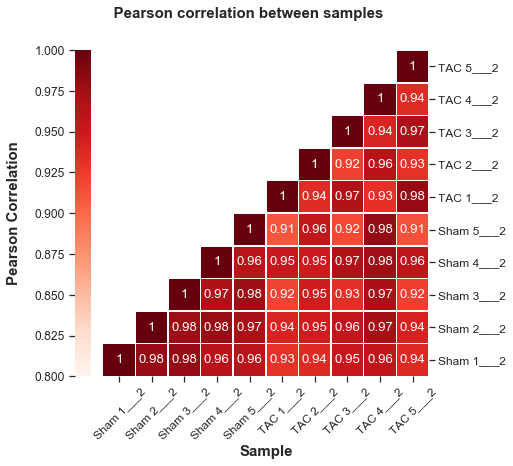

In [83]:
# filter df_phosphosites_log for doubly phosphorylated peptides
df_phosphosites_log__2 = df_phosphosites_log.filter(regex="___2")

# calculate pearson correlation between samples and visualize by plotting a heat map
corr_plot = plot_sample_correlation(df_phosphosites_log__2, title="                    Pearson correlation between samples")

save_figure(corr_plot, "sample_correlation___2")

### Multiplicity 3

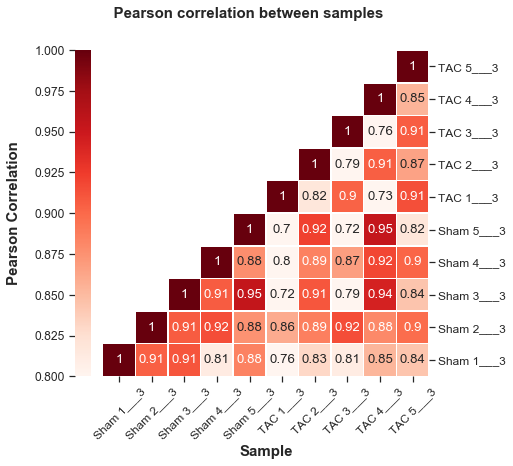

In [84]:
# filter df_phosphosites_log for doubly phosphorylated peptides
df_phosphosites_log__3 = df_phosphosites_log.filter(regex="___3")

# calculate pearson correlation between samples and visualize by plotting a heat map
corr_plot = plot_sample_correlation(df_phosphosites_log__3, title="                    Pearson correlation between samples")

save_figure(corr_plot, "sample_correlation___3")

## Add all other columns that were removed earlier back to the dataframe

In [73]:
identifier_col = df_phosphosites["Phospho (STY) Probabilities"].astype(str) + "|" + df_phosphosites["Positions"].astype(str)

# filter df_phosphosites for sites that are present in df_proteinGroups_log
df_phosphosites_filtered = df_phosphosites[identifier_col.isin(df_phosphosites_log.index)]

In [74]:
# check of the order of sites is still the same
sum(df_phosphosites_log.index != identifier_col)

0

In [76]:
# combine dataframe
df_phosphosites_log.reset_index(drop=True, inplace=True)
df_phosphosites_filtered.reset_index(drop=True, inplace=True)

df_phosphosites_log_combined = pd.concat([df_phosphosites_log, df_phosphosites_filtered], axis=1)
df_phosphosites_log_combined.head(5)

,Sham 1___1,Sham 1___2,Sham 1___3,Sham 2___1,Sham 2___2,Sham 2___3,Sham 3___1,Sham 3___2,Sham 3___3,Sham 4___1,...,Best localization raw file,Best localization scan number,Best score evidence ID,Best score MS/MS ID,Best score raw file,Best score scan number,Best PEP evidence ID,Best PEP MS/MS ID,Best PEP raw file,Best PEP scan number
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,13091,64949,35901,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,13091,64949,35901,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,13091
1,16.694793,NaN,NaN,16.576853,NaN,NaN,16.311198,NaN,NaN,16.875437,...,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8019,67468,37230,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8019,67468,37230,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8019
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8661,51603,29023,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8661,51603,29023,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8661
3,15.980407,NaN,NaN,14.912188,NaN,NaN,15.465343,NaN,NaN,15.497446,...,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,2037,20828,11582,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,1657,20828,11582,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,1657
4,NaN,14.28663,NaN,NaN,14.196218,NaN,NaN,14.459047,NaN,NaN,...,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8690,29243,16486,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8690,29243,16486,20191223_QE9_nLC13_SM_SA_MOUSE_PKP2KO_HF-SN_TM...,8690


### Save df_proteinGroups_log as csv file

In [77]:
# create new path name for saving dataframe as csv
path_df = folder_output + "\\Phospho (STY)Sites_log.csv"

# write to file
df_phosphosites_log_combined.to_csv(path_df)